# Introduction to Physics-Informed Neural Networks (PINNs) 

Physics-Informed Neural Networks (PINNs) are a class of deep learning models that incorporate known physical laws—typically in the form of partial differential equations (PDEs)—directly into the training process. Unlike traditional neural networks that rely solely on data, PINNs leverage governing equations to constrain the solution space, leading to more accurate and physically consistent predictions even with limited training data.  

### **How PINNs Work**  

1. **Neural Network Structure**: PINNs typically use a fully connected feedforward neural network to approximate the solution of a PDE. The input can be spatial and temporal coordinates \((x, y, t)\), and the output is the predicted state variable (e.g., temperature, velocity, displacement, etc.).  

2. **Loss Function**: The key feature of PINNs is the inclusion of physics-based loss terms:  
   - **Residual Loss**: The network minimizes the error in satisfying the governing PDE at sampled points. In essence, we are training the derivatives of the network to be consistent with the derivatives of a governing PDE. The network *becomes* the function (well, more accurately, we are forcing the learned function to behave *as if* it is a differentiable solution to the PDE).
   - **Boundary/Initial Condition Loss**: Additional loss terms enforce constraints at the boundaries and initial states of the system.  
   - **Data Loss (if available)**: If experimental or simulation data exist, they can be included as another loss term.  

3. **Training Process**: PINNs are trained using gradient-based optimization, ensuring that the learned solution not only fits available data but also adheres to the underlying physical laws.  

### **Advantages of PINNs**  

- **Data Efficiency**: Since physical laws act as a built-in regularizer, PINNs require fewer data points than purely data-driven models.  
- **Generalization**: The network can extrapolate better to unseen conditions by leveraging physics-based constraints.  
- **Solution to Inverse Problems**: PINNs are particularly useful for discovering unknown parameters in PDEs, such as material properties or hidden forces. 
- **Mesh Free solutions**: Traditional numerical solutions for PDEs, i.e., finite element or finite difference methods, require discretization (meshes). They can be computationally expensive for high-dimensional solutions or when you want high spatial/temporal resolution. PINNs solve PDEs in a continuous space, making them more flexible. 

### **Applications**  

Example applications of PINNs include:  
- Fluid dynamics (e.g., Navier-Stokes equations)  
- Heat transfer and diffusion processes  
- Electromagnetics and quantum mechanics  
- Geophysics and climate modeling  


In [3]:
# imports
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

from network import Net, NetDiscovery
from diff_equations import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)

print(DEVICE)


cpu


# Cooling cup of coffee
### Following Newton's Law of Cooling (with constant environmental temp.):

$$ \frac{dT}{dt} = R \cdot (T_{\text{env}} - T(t)) $$

Solving with $T_{\text{env}}$ as a constant:

$$ T(t) = T_{\text{env}} + (T_0 - T_{\text{env}}) \cdot e^{-R \cdot \text{time}} $$


Text(0.5, 0, 'Time (s)')

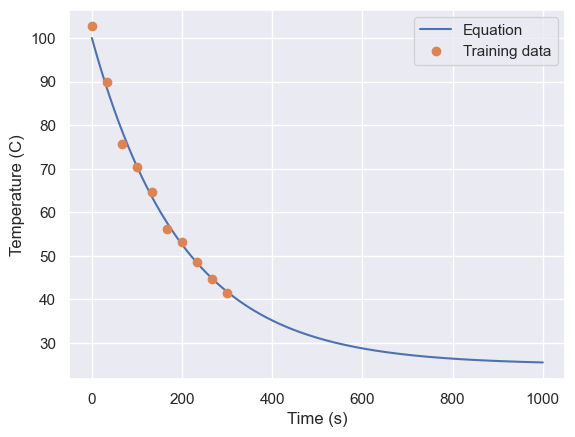

In [4]:
#generate data

np.random.seed(10)

Tenv = 25 # degrees C
T0 = 100 # degrees C, hot coffee
R = 0.005
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) +  2 * np.random.randn(10)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')


# Networks with no regularization

Epoch 0/20000, loss: 4713.87
Epoch 2000/20000, loss: 2509.96
Epoch 4000/20000, loss: 2141.73
Epoch 6000/20000, loss: 727.16
Epoch 8000/20000, loss: 88.06
Epoch 10000/20000, loss: 2.06
Epoch 12000/20000, loss: 0.47
Epoch 14000/20000, loss: 0.40
Epoch 16000/20000, loss: 0.36
Epoch 18000/20000, loss: 0.34


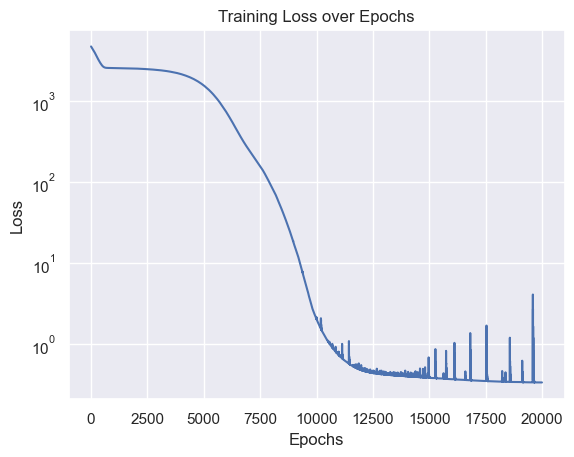

In [5]:
# Initialize a neural network with 1 input and 1 output. 
# The loss2 parameter is set to None, meaning no additional custom loss is used.
# The network will train for 20000 epochs with a learning rate of 1e-5.
net = Net(1, 1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

# Fit the network to the training data (t, T).
# The fit method will return the losses over the training period.
losses = net.fit(t, T)

# Plot the training losses to visualize the training process.
# The y-axis is set to a logarithmic scale to better visualize the loss reduction over time.
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [6]:
def l2_reg(model: torch.nn.Module):
    """
    Compute the L2 regularization term for a given model.
    
    L2 regularization, also known as weight decay, is a technique used to prevent overfitting
    by penalizing large weights in the model. This is done by adding a term to the loss function
    that is proportional to the sum of the squared values of the weights.
    
    Args:
    model (torch.nn.Module): The neural network model whose parameters will be regularized.
    
    Returns:
    torch.Tensor: The L2 regularization term.
    """
    # Initialize the regularization term to zero
    reg_term = 0.0
    
    # Iterate over all parameters of the model
    for p in model.parameters():
        # Add the sum of squares of the parameter values to the regularization term
        reg_term += torch.sum(p.pow(2.))
    
    return reg_term

Epoch 0/20000, loss: 4787.99
Epoch 2000/20000, loss: 134.32
Epoch 4000/20000, loss: 111.94
Epoch 6000/20000, loss: 97.24
Epoch 8000/20000, loss: 88.97
Epoch 10000/20000, loss: 85.40
Epoch 12000/20000, loss: 83.70
Epoch 14000/20000, loss: 76.45
Epoch 16000/20000, loss: 74.44
Epoch 18000/20000, loss: 73.34


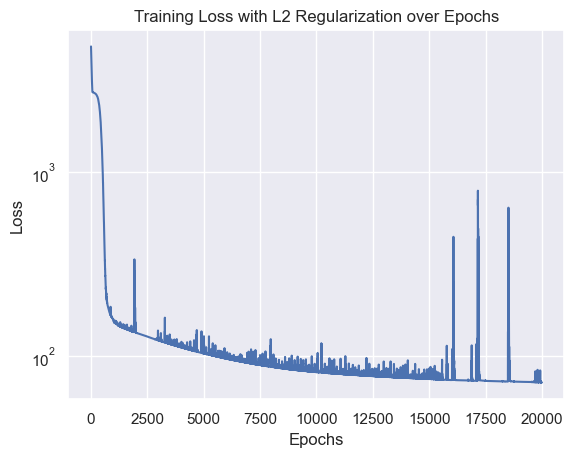

In [7]:
# Initialize a neural network with 1 input and 1 output.
# The network uses L2 regularization (weight decay) to prevent overfitting.
# The network will train for 20000 epochs with a learning rate of 1e-4.
# The loss2_weight parameter is set to 1, meaning the L2 regularization term will be added to the loss function.
netreg = Net(1, 1, loss2=l2_reg, epochs=20000, lr=1e-4, loss2_weight=1).to(DEVICE)

# Fit the network to the training data (t, T).
# The fit method will return the losses over the training period.
losses = netreg.fit(t, T)

# Plot the training losses to visualize the training process.
# The y-axis is set to a logarithmic scale to better visualize the loss reduction over time.
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss with L2 Regularization over Epochs')
plt.show()

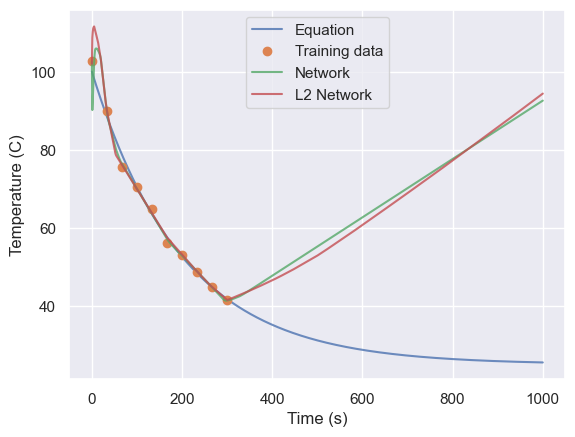

In [8]:
# Predict temperatures using the neural network without regularization
preds = net.predict(times)

# Predict temperatures using the neural network with L2 regularization
predsreg = netreg.predict(times)

# Plot the true temperature curve from the differential equation
plt.plot(times, temps, alpha=0.8)

# Plot the training data points
plt.plot(t, T, 'o')

# Plot the predictions from the neural network without regularization
plt.plot(times, preds, alpha=0.8)

# Plot the predictions from the neural network with L2 regularization
plt.plot(times, predsreg, alpha=0.8)

# Add a legend to differentiate between the different plots
plt.legend(labels=['Equation', 'Training data', 'Network', 'L2 Network'])

# Label the y-axis as 'Temperature (C)'
plt.ylabel('Temperature (C)')

# Label the x-axis as 'Time (s)'
plt.xlabel('Time (s)')

# Display the plot
plt.show()


# PINN

In [13]:
def physics_loss(model: torch.nn.Module):
    """
    Compute the physics-informed loss for the given model.
    
    This function calculates the loss based on the physical laws governing the system.
    Specifically, it uses the differential equation for cooling to compute the loss.
    
    Args:
    model (torch.nn.Module): The neural network model whose parameters will be optimized.
    
    Returns:
    torch.Tensor: The physics-informed loss.
    """
    # Generate a tensor of time steps from 0 to 1000, with 1000 steps in total.
    # The view(-1,1) reshapes the tensor to have one column and multiple rows.
    # The requires_grad_(True) ensures that gradients can be computed with respect to these time steps.
    ts = torch.linspace(0, 1000, steps=1000).view(-1, 1).requires_grad_(True).to(DEVICE)
    
    # Use the model to predict temperatures at the given time steps.
    temps = model(ts)
    
    # Compute the gradient of the temperatures with respect to time.
    # This gives us the rate of change of temperature with respect to time.
    dT = grad(temps, ts)[0]
    
    # Compute the residual of the differential equation.
    # The differential equation for cooling is given by: dT/dt = -R * (T - Tenv)
    # Rearranging this equation, we get: R * (Tenv - T) - dT/dt = 0
    # The residual is the difference between the left-hand side and the right-hand side of this equation.
    pde = R * (Tenv - temps) - dT
    
    # Compute the mean squared error of the residuals.
    # This gives us the physics-informed loss, which we aim to minimize during training.
    return torch.mean(pde**2)

Epoch 0/30000, loss: 4816.04
Epoch 3000/30000, loss: 2393.90
Epoch 6000/30000, loss: 479.87
Epoch 9000/30000, loss: 1.42
Epoch 12000/30000, loss: 0.89
Epoch 15000/30000, loss: 0.66
Epoch 18000/30000, loss: 0.41
Epoch 21000/30000, loss: 0.20
Epoch 24000/30000, loss: 0.11
Epoch 27000/30000, loss: 0.07


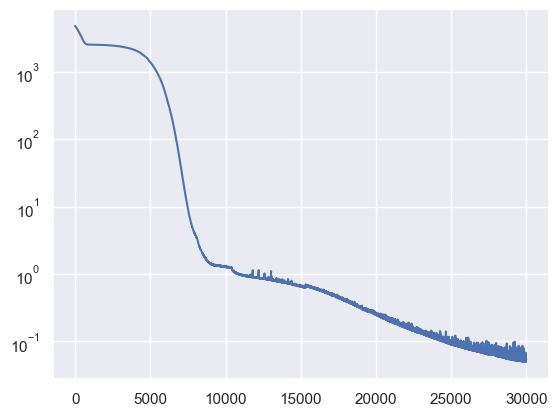

In [14]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)
"""
This script demonstrates the process of training a neural network to predict temperature over time 
using physics-informed neural networks (PINNs). 

Classes:
    Net: A neural network class that includes methods for training and loss calculation.

Functions:
    fit: A method of the Net class that trains the neural network on the provided data.

Variables:
    net (Net): An instance of the Net class initialized with specific parameters.
    losses (list): A list of loss values recorded during the training process.
    t (torch.Tensor): A tensor representing the time data.
    T (torch.Tensor): A tensor representing the temperature data.
    DEVICE (torch.device): The device (CPU or GPU) on which the computations will be performed.

Code Description:
    1. Initialize the neural network (net) with the following parameters:
        - Input dimension: 1 (time)
        - Output dimension: 1 (temperature)
        - loss2: A custom physics-based loss function (physics_loss)
        - epochs: Number of training epochs (30000)
        - loss2_weight: Weight of the physics-based loss in the total loss calculation (1)
        - lr: Learning rate for the optimizer (1e-5)
        - DEVICE: The device on which the model will be trained (CPU or GPU)

    2. Train the neural network using the fit method:
        - t: Time data
        - T: Temperature data
        - The fit method returns a list of loss values recorded during the training process.

    3. Plot the training losses:
        - Use matplotlib to plot the loss values.
        - Set the y-axis to a logarithmic scale for better visualization of the loss reduction over time.
"""

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')

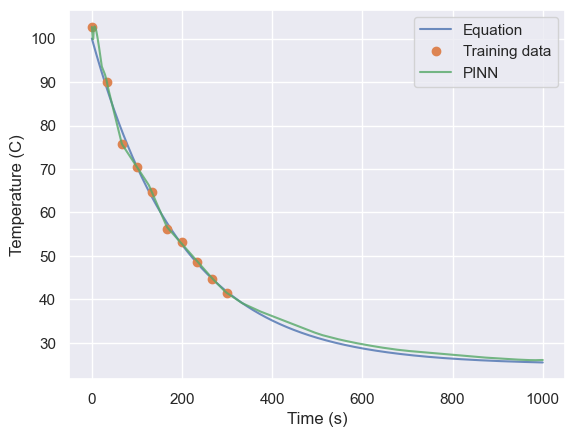

In [15]:
# Use the trained neural network (net) to predict temperatures over the given time steps.
# The times variable contains the time steps at which predictions are made.
preds = net.predict(times)

# Plot the true temperature curve obtained from the differential equation.
# This represents the actual physical behavior of the cooling process.
plt.plot(times, temps, alpha=0.8)

# Plot the training data points.
# These points were used to train the neural network and include some noise.
plt.plot(t, T, 'o')

# Plot the predictions made by the neural network.
# This shows how well the neural network has learned to approximate the true temperature curve.
plt.plot(times, preds, alpha=0.8)

# Add a legend to differentiate between the different plots.
# 'Equation' refers to the true temperature curve from the differential equation.
# 'Training data' refers to the noisy data points used for training.
# 'PINN' refers to the predictions made by the Physics-Informed Neural Network.
plt.legend(labels=['Equation', 'Training data', 'PINN'])

# Label the y-axis as 'Temperature (C)'.
# This indicates that the y-axis represents temperature in degrees Celsius.
plt.ylabel('Temperature (C)')

# Label the x-axis as 'Time (s)'.
# This indicates that the x-axis represents time in seconds.
plt.xlabel('Time (s)')

# Display the plot.
# This will show the true temperature curve, the training data points, and the neural network predictions on the same graph.
plt.show()

# Parameter discovery

In [16]:
def physics_loss_discovery(model: torch.nn.Module):
    """
    Compute the physics-informed loss for parameter discovery in the given model.
    
    This function calculates the loss based on the physical laws governing the system,
    specifically using the differential equation for cooling to compute the loss.
    The goal is to discover the parameter 'r' that best fits the observed data.
    
    Args:
    model (torch.nn.Module): The neural network model whose parameters will be optimized.
    
    Returns:
    torch.Tensor: The physics-informed loss.
    """
    # Generate a tensor of time steps from 0 to 1000, with 1000 steps in total.
    # The view(-1,1) reshapes the tensor to have one column and multiple rows.
    # The requires_grad_(True) ensures that gradients can be computed with respect to these time steps.
    ts = torch.linspace(0, 1000, steps=1000).view(-1, 1).requires_grad_(True).to(DEVICE)
    
    # Use the model to predict temperatures at the given time steps.
    temps = model(ts)
    
    # Compute the gradient of the temperatures with respect to time.
    # This gives us the rate of change of temperature with respect to time.
    dT = grad(temps, ts)[0]
    
    # Compute the residual of the differential equation.
    # The differential equation for cooling is given by: dT/dt = -r * (T - Tenv)
    # Rearranging this equation, we get: r * (Tenv - T) - dT/dt = 0
    # The residual is the difference between the left-hand side and the right-hand side of this equation.
    pde = model.r * (Tenv - temps) - dT
    
    # Compute the mean squared error of the residuals.
    # This gives us the physics-informed loss, which we aim to minimize during training.
    return torch.mean(pde**2)

Epoch 0/20000, loss: 4605.26
Epoch 2000/20000, loss: 2546.67
Epoch 4000/20000, loss: 2478.02
Epoch 6000/20000, loss: 2300.41
Epoch 8000/20000, loss: 1851.66
Epoch 10000/20000, loss: 1052.27
Epoch 12000/20000, loss: 281.24
Epoch 14000/20000, loss: 14.69
Epoch 16000/20000, loss: 4.34
Epoch 18000/20000, loss: 3.90


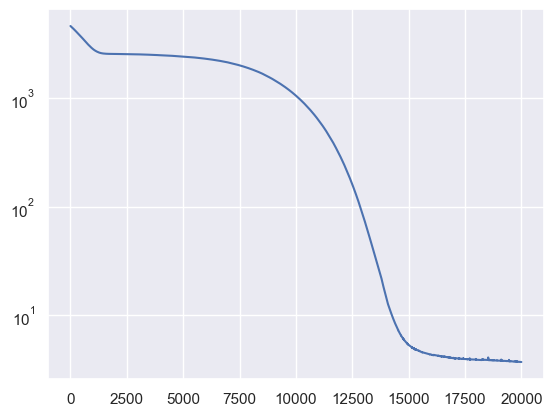

In [17]:
netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=20000, lr= 5e-6).to(DEVICE)
"""
Classes:
    NetDiscovery: A neural network class designed for discovering the r parameter of Netwon's heat equation.

Functions:
    physics_loss_discovery: A custom loss function that incorporates Newton's cooling law into the training process.

Variables:
    netdisc (NetDiscovery): An instance of the NetDiscovery class.
    losses (list): A list of loss values recorded during the training process.

Code:
    netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr=5e-6).to(DEVICE)
        - Initializes the NetDiscovery instance with:
            - Input dimension: 1
            - Output dimension: 1
            - Custom physics-based loss function: physics_loss_discovery
            - Weight for the custom loss function: 1
            - Number of training epochs: 40000
            - Learning rate: 5e-6
        - Moves the model to the specified device (e.g., CPU or GPU).

        - Trains the neural network using the provided time (t) and temperature (T) data.
        - Returns a list of loss values recorded during the training process.

        - Plots the loss values over the training epochs.

        - Sets the y-axis scale of the plot to logarithmic to better visualize the loss values over a wide range.
"""

losses = netdisc.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Parameter containing:
tensor([0.0090], requires_grad=True)


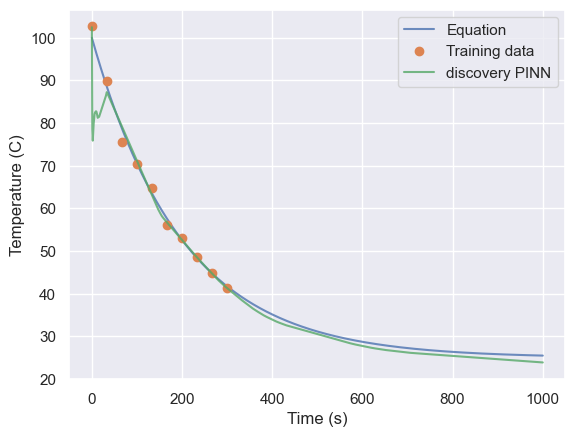

In [18]:
# Use the trained neural network (netdisc) to predict temperatures over the given time steps.
# The times variable contains the time steps at which predictions are made.
preds = netdisc.predict(times)

# Print the discovered parameter 'r' from the neural network.
# This parameter is part of the differential equation and was learned during training.
print(netdisc.r)

# Plot the true temperature curve obtained from the differential equation.
# This represents the actual physical behavior of the cooling process.
plt.plot(times, temps, alpha=0.8)

# Plot the training data points.
# These points were used to train the neural network and include some noise.
plt.plot(t, T, 'o')

# Plot the predictions made by the neural network.
# This shows how well the neural network has learned to approximate the true temperature curve.
plt.plot(times, preds, alpha=0.8)

# Add a legend to differentiate between the different plots.
# 'Equation' refers to the true temperature curve from the differential equation.
# 'Training data' refers to the noisy data points used for training.
# 'discovery PINN' refers to the predictions made by the Physics-Informed Neural Network used for parameter discovery.
plt.legend(labels=['Equation', 'Training data', 'discovery PINN'])

# y Label
plt.ylabel('Temperature (C)')

# x Label 
plt.xlabel('Time (s)')
plt.show()